# 95-865: Prediction and Model Validation

Author: George H. Chen (georgechen [at symbol] cmu.edu)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

np.random.seed(0)

# these next two lines are needed on my old Intel Mac laptop due to some weird software update issue and also a memory issue
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '1'

### Loading in the data and a quick data inspection

In [2]:
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 10467140.22it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34433113.65it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 8838369.29it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8639695.59it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_images = np.array([image.numpy() for image, label in train_dataset])

In [4]:
train_labels = np.array([label for image, label in train_dataset])

In [5]:
train_images.shape

(60000, 1, 28, 28)

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8])

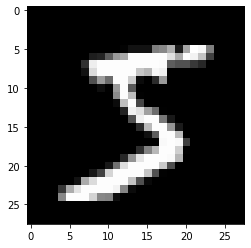

In [7]:
plt.imshow(train_images[0][0], cmap='gray')

In [8]:
train_images = train_images[:5000]
train_labels = train_labels[:5000]
train_images_flat = train_images.reshape(len(train_images), -1)  # flattens out each training image

In [9]:
print(train_images_flat.shape)

(5000, 784)


### Classification using $k$-nearest neighbors

In [10]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_images_flat, train_labels)

KNeighborsClassifier(n_neighbors=1)

In [11]:
predicted_train_labels = classifier.predict(train_images_flat)

In [12]:
predicted_train_labels

array([5, 0, 4, ..., 2, 1, 2])

In [13]:
predicted_train_labels == train_labels

array([ True,  True,  True, ...,  True,  True,  True])

In [14]:
raw_accuracy = np.mean(predicted_train_labels == train_labels)
print(raw_accuracy)

1.0


### Choosing hyperparameter $k$ (number of nearest neighbors) using a validation set

In [15]:
from sklearn.model_selection import train_test_split

proper_train_images_flat, val_images_flat, proper_train_labels, val_labels = \
    train_test_split(train_images_flat, train_labels, test_size=0.2, random_state=0)

In [16]:
best_score = -np.inf
best_k = None
best_model = None

for k in 2**np.arange(0, 8):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(proper_train_images_flat, proper_train_labels)
    predicted_val_labels = classifier.predict(val_images_flat)
    score = np.mean(predicted_val_labels == val_labels)  # raw accuracy
    print('k:', k, 'accuracy:', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = classifier

print('Best k:', best_k, 'accuracy:', best_score)

k: 1 accuracy: 0.93
k: 2 accuracy: 0.921
k: 4 accuracy: 0.925
k: 8 accuracy: 0.92
k: 16 accuracy: 0.907
k: 32 accuracy: 0.887
k: 64 accuracy: 0.86
k: 128 accuracy: 0.815
Best k: 1 accuracy: 0.93


### Searching over multiple hyperparameters

In [17]:
best_score = -np.inf
best_hyperparam_setting = None
best_model = None

list_of_hyperparam_settings = [(k, dist)
                               for k in 2**np.arange(0, 8)
                               for dist in ['euclidean', 'cosine', 'manhattan']]

In [18]:
list_of_hyperparam_settings

[(1, 'euclidean'),
 (1, 'cosine'),
 (1, 'manhattan'),
 (2, 'euclidean'),
 (2, 'cosine'),
 (2, 'manhattan'),
 (4, 'euclidean'),
 (4, 'cosine'),
 (4, 'manhattan'),
 (8, 'euclidean'),
 (8, 'cosine'),
 (8, 'manhattan'),
 (16, 'euclidean'),
 (16, 'cosine'),
 (16, 'manhattan'),
 (32, 'euclidean'),
 (32, 'cosine'),
 (32, 'manhattan'),
 (64, 'euclidean'),
 (64, 'cosine'),
 (64, 'manhattan'),
 (128, 'euclidean'),
 (128, 'cosine'),
 (128, 'manhattan')]

In [19]:
for hyperparam_setting in list_of_hyperparam_settings:
    k, dist = hyperparam_setting

    classifier = KNeighborsClassifier(n_neighbors=k, metric=dist)
    classifier.fit(proper_train_images_flat, proper_train_labels)
    predicted_val_labels = classifier.predict(val_images_flat)
    score = np.mean(predicted_val_labels == val_labels)
    print('Hyperparameter setting:', hyperparam_setting, 'accuracy:', score)

    if score > best_score:
        best_score = score
        best_hyperparam_setting = hyperparam_setting
        best_model = classifier

print('Best hyperparameter setting:', best_hyperparam_setting, 'accuracy:', best_score)

Hyperparameter setting: (1, 'euclidean') accuracy: 0.93
Hyperparameter setting: (1, 'cosine') accuracy: 0.946
Hyperparameter setting: (1, 'manhattan') accuracy: 0.918
Hyperparameter setting: (2, 'euclidean') accuracy: 0.921
Hyperparameter setting: (2, 'cosine') accuracy: 0.935
Hyperparameter setting: (2, 'manhattan') accuracy: 0.903
Hyperparameter setting: (4, 'euclidean') accuracy: 0.925
Hyperparameter setting: (4, 'cosine') accuracy: 0.939
Hyperparameter setting: (4, 'manhattan') accuracy: 0.914
Hyperparameter setting: (8, 'euclidean') accuracy: 0.92
Hyperparameter setting: (8, 'cosine') accuracy: 0.946
Hyperparameter setting: (8, 'manhattan') accuracy: 0.912
Hyperparameter setting: (16, 'euclidean') accuracy: 0.907
Hyperparameter setting: (16, 'cosine') accuracy: 0.926
Hyperparameter setting: (16, 'manhattan') accuracy: 0.887
Hyperparameter setting: (32, 'euclidean') accuracy: 0.887
Hyperparameter setting: (32, 'cosine') accuracy: 0.91
Hyperparameter setting: (32, 'manhattan') accur

### Finally actually looking at the test data

In [20]:
test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)
test_images = np.array([image.numpy() for image, label in test_dataset])
test_labels = np.array([label for image, label in test_dataset])

test_images_flat = test_images.reshape(len(test_images), -1)  # flattens out each test image

In [21]:
test_images_flat.shape

(10000, 784)

In [22]:
predicted_test_labels = best_model.predict(test_images_flat)
test_set_accuracy = np.mean(predicted_test_labels == test_labels)
print(test_set_accuracy)

0.9375


### Confusion matrix

We can visualize to see where (in terms of which classes) predictions agree or disagree with the true labels on the test set. This can help us quickly see which classes seem to be hard cases.

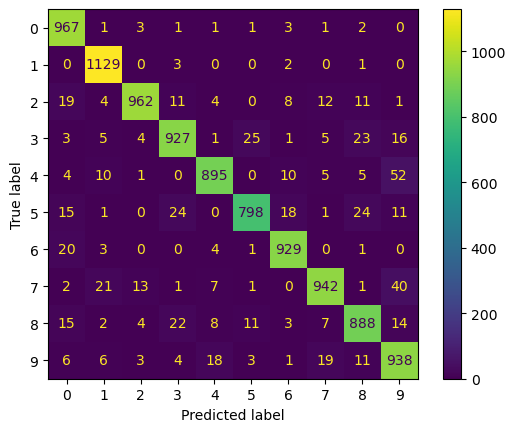

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, best_model.predict(test_images_flat),
                      labels=best_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=best_model.classes_).plot()